## Loading data

In [373]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from scipy.stats import chi2_contingency, kruskal
import os
import warnings
warnings.filterwarnings("ignore")

In [374]:
base_path = "../data/full"
# algo = "reverse_hybrid"
algo = "w_slpa"
patient_df = pd.read_csv("../../data/thesis/cll_broad_2022_clinical_data_thesis.csv")
mutation_df = pd.read_csv("../../data/thesis/cll_broad_2022_mutations_thesis.csv")
community_df = pd.read_csv(os.path.join(base_path, algo, "community_assignments.csv"))

## Tagging community (response based labels)

In [375]:
# Count how many communities each patient belongs to
comm_count = community_df.groupby('patientId').size().reset_index(name='comm_count')
overlapping = comm_count[comm_count['comm_count'] > 1]['patientId']
community_df['is_overlap'] = community_df['patientId'].isin(overlapping)

# Merge community and patient info
merged = pd.merge(community_df, patient_df, on='patientId')
merged['FFS_STATUS'] = merged['FFS_STATUS'].map(lambda x: int(x[0]))
merged['OS_STATUS'] = merged['OS_STATUS'].map(lambda x: int(x[0]))

# patient_df[['FFS_MONTHS', 'FFS_STATUS', 'OS_MONTHS', 'OS_STATUS']][0:5]
# FFS 1 means failure, OS 1 means deceased

In [376]:
# function that print value counts of OS_STATUS and FFS_STATUS for each community
def print_status_counts(df, groupby='communityId'):
    print("\n🔍 OS_STATUS counts per community:")
    os_counts = df.groupby(groupby)['OS_STATUS'].value_counts().unstack(fill_value=0)
    print(os_counts)

    print("\n🔍 FFS_STATUS counts per community:")
    ffs_counts = df.groupby(groupby)['FFS_STATUS'].value_counts().unstack(fill_value=0)
    print(ffs_counts)

In [377]:
print_status_counts(merged)


🔍 OS_STATUS counts per community:
OS_STATUS      0    1
communityId          
0              0  286
1             66    0
2            331    0
3            379    0

🔍 FFS_STATUS counts per community:
FFS_STATUS     0    1
communityId          
0              0  286
1              0   66
2              0  331
3            372    7


In [378]:
# ---------------------------
# 📌 Q1: COMMUNITY LABELING
# ---------------------------
response_means = merged.groupby('communityId')[['FFS_MONTHS', 'FFS_STATUS', 'OS_MONTHS', 'OS_STATUS']].mean().round(5)
response_counts = merged['communityId'].value_counts().rename("num_patients")
summary = pd.concat([response_counts, response_means], axis=1).sort_index()

print("📊 Community Survival Summary")

# Optional: Visual tag
community_tags = {
    0: {
        'tag': 'Poor Responders (Early Failure & Death)',
        'description': 'All patients failed early (FFS = 29.8 mo) and deceased (OS = 57.2 mo), indicating uniformly poor outcomes.'
    },
    1: {
        'tag': 'Early Failures, Long-Term Survivors',
        'description': 'Despite failing treatment (FFS = 30.7 mo), all patients are still alive (OS = 154.3 mo), showing resilient survival post-failure.',
    },
    2: {
        'tag': 'Moderate Responders',
        'description': 'Patients failed after a moderate duration (FFS = 39.6 mo) but all remain alive (OS = 89.8 mo), representing an intermediate response group.'
    },
    3: {
        'tag': 'Strong Responders (Treatment Durable)',
        'description': 'Nearly all patients (98%) remain failure-free (FFS = 84.8 mo) and alive (OS = 85.4 mo), marking the most successful treatment outcomes.'
    }
}
    # Example
summary = summary.reset_index()
summary.rename(columns={'index': 'communityId'}, inplace=True)
summary['tag'] = summary['communityId'].map(community_tags).apply(lambda x: x['tag'])
summary['description'] = summary['communityId'].map(community_tags).apply(lambda x: x['description'])

display(summary)

📊 Community Survival Summary


,communityId,num_patients,FFS_MONTHS,FFS_STATUS,OS_MONTHS,OS_STATUS,tag,description
0,0,286,29.77395,1.00000,57.19182,1.0,Poor Responders (Early Failure & Death),All patients failed early (FFS = 29.8 mo) and ...
1,1,66,30.69864,1.00000,154.28258,0.0,"Early Failures, Long-Term Survivors","Despite failing treatment (FFS = 30.7 mo), all..."
2,2,331,39.59656,1.00000,89.80595,0.0,Moderate Responders,Patients failed after a moderate duration (FFS...
3,3,379,84.78063,0.01847,85.44306,0.0,Strong Responders (Treatment Durable),Nearly all patients (98%) remain failure-free ...


## Clinical attribute comparisons

📍 Overlap Pairs Distribution


comm_pair
[1, 2]    49
[2, 3]     5
Name: count, dtype: int64

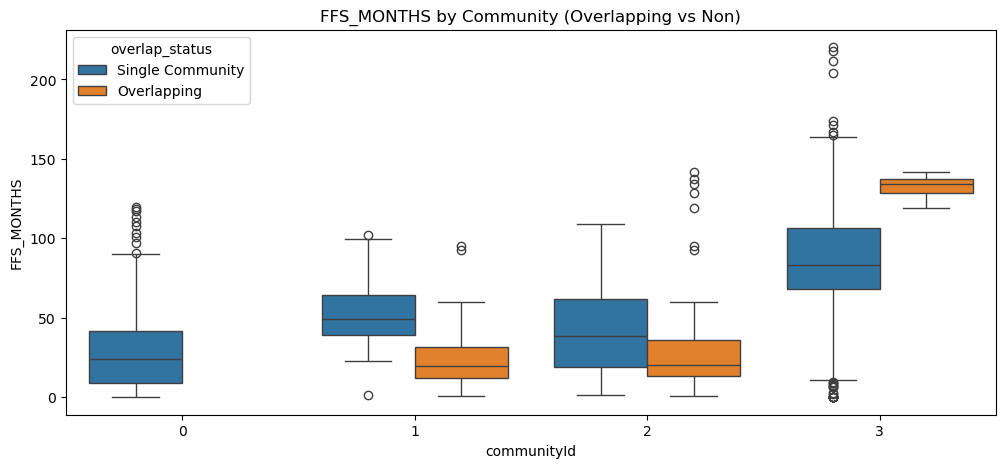

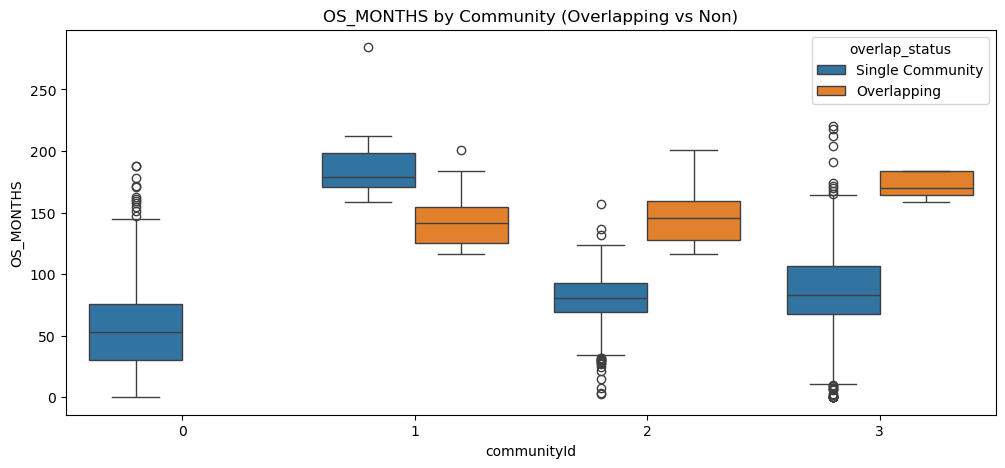

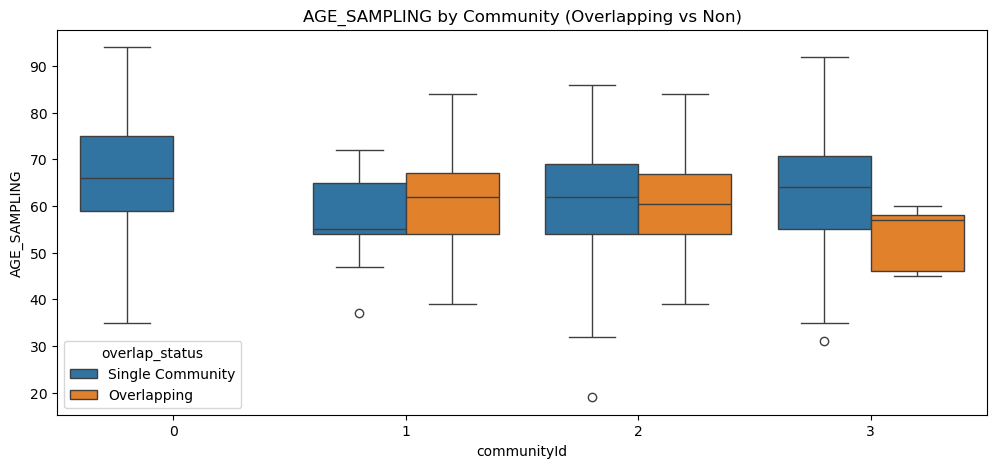

In [379]:
# ---------------------------
# 📌 Q2: ANALYSIS OF OVERLAPPING NODES
# ---------------------------
# A. Basic overlap distribution
overlap_pairs = community_df[community_df['is_overlap']].groupby('patientId')['communityId'].apply(sorted).reset_index()
overlap_pairs['comm_pair'] = overlap_pairs['communityId'].apply(lambda x: str(x))
pair_counts = overlap_pairs['comm_pair'].value_counts()

print("📍 Overlap Pairs Distribution")
display(pair_counts)

# B. Annotate each overlapping node with their pair
community_df = pd.merge(community_df, overlap_pairs[['patientId', 'comm_pair']], on='patientId', how='left')

# C. Compare attributes across overlapping vs non-overlapping
merged['overlap_status'] = merged['is_overlap'].map({True: 'Overlapping', False: 'Single Community'})

# Example: boxplot of survival times
def plot_overlap(merged, ycol):
    plt.figure(figsize=(12,5))
    sns.boxplot(data=merged, x='communityId', y=ycol, hue='overlap_status')
    plt.title(f"{ycol} by Community (Overlapping vs Non)")
    plt.show()

plot_overlap(merged, 'FFS_MONTHS')
plot_overlap(merged, 'OS_MONTHS')
plot_overlap(merged, 'AGE_SAMPLING')

In [380]:
def compare_overlap_without_overlap(merged, comm_id_1, comm_id_2):
    # Assign group labels: '[1, 2]', '[1]', '[2]', NaN
    comm_pair_str = f'[{comm_id_1}, {comm_id_2}]'
    merged = merged.copy()
    merged['overlap_group'] = np.nan
    # [1,2] overlap group
    comm_12 = set(overlap_pairs[overlap_pairs['comm_pair'] == comm_pair_str]['patientId'])
    merged.loc[merged['patientId'].isin(comm_12), 'overlap_group'] = comm_pair_str
    # Only 1 group
    only_1 = set(community_df[(community_df['communityId'] == comm_id_1) & (~community_df['is_overlap'])]['patientId'])
    merged.loc[merged['patientId'].isin(only_1), 'overlap_group'] = f'[{comm_id_1}]'
    # Only 2 group
    only_2 = set(community_df[(community_df['communityId'] == comm_id_2) & (~community_df['is_overlap'])]['patientId'])
    merged.loc[merged['patientId'].isin(only_2), 'overlap_group'] = f'[{comm_id_2}]'
    
    # D. Categorical distribution by overlap_group
    columns = [
        'SEX',
        'IGHV_MUTATION_STATUS',
        'CLL_EPITYPE', 
        'TUMOR_MOLECULAR_SUBTYPE', 
        'PRIOR_TREATMENT_CATEGORY',
        'TREATMENT_AFTER_SAMPLING'
    ]
    for col in columns:
        print(f"🔍 {col} Distribution by Overlap Group:")
        ct = pd.crosstab(merged['overlap_group'], merged[col], normalize='index')
        display(ct.style.format("{:.1%}"))
    
    # Numeric summary table: rows = groups, columns = min, q1, mean, q3, max, std
    numeric_cols = ['AGE_SAMPLING', 'FFS_MONTHS', 'OS_MONTHS', 'MUTATION_COUNT']
    for num_col in numeric_cols:
        print(f"\nSummary for {num_col} by Overlap Group:")
        stats = []
        for group in [comm_pair_str, f'[{comm_id_1}]', f'[{comm_id_2}]']:
            # Filter based on overlap group
            filtered = merged[merged['overlap_group'] == group]

            # Apply additional filtering for survival columns
            if num_col == 'OS_MONTHS':
                filtered = filtered[filtered['OS_STATUS'] == 1]
            elif num_col == 'FFS_MONTHS':
                filtered = filtered[filtered['FFS_STATUS'] == 1]

            vals = filtered.loc[filtered['overlap_group'] == group, num_col].dropna()
            if len(vals) > 0:
                stats.append({
                    'Group': group,
                    'min': vals.min(),
                    'q1': vals.quantile(0.25),
                    'median': vals.median(),
                    'mean': vals.mean(),
                    'q3': vals.quantile(0.75),
                    'max': vals.max(),
                    'std': vals.std()
                })
            else:
                stats.append({
                    'Group': group,
                    'min': np.nan,
                    'q1': np.nan,
                    'mean': np.nan,
                    'median': np.nan,
                    'q3': np.nan,
                    'max': np.nan,
                    'std': np.nan
                })
        stats_df = pd.DataFrame(stats).set_index('Group')
        display(stats_df)

In [381]:
compare_overlap_without_overlap(merged, 1, 2)

🔍 SEX Distribution by Overlap Group:


SEX,Female,Male
overlap_group,,
"[1, 2]",40.8%,59.2%
[1],23.5%,76.5%
[2],32.1%,67.9%


🔍 IGHV_MUTATION_STATUS Distribution by Overlap Group:


IGHV_MUTATION_STATUS,mutated,unmutated
overlap_group,,
"[1, 2]",49.0%,51.0%
[1],52.9%,47.1%
[2],39.1%,60.9%


🔍 CLL_EPITYPE Distribution by Overlap Group:


CLL_EPITYPE,i-CLL,m-CLL,n-CLL,unclassified
overlap_group,,,,
"[1, 2]",8.2%,26.5%,26.5%,38.8%
[1],17.6%,29.4%,35.3%,17.6%
[2],16.6%,22.0%,50.9%,10.5%


🔍 TUMOR_MOLECULAR_SUBTYPE Distribution by Overlap Group:


TUMOR_MOLECULAR_SUBTYPE,M-CLL,U-CLL
overlap_group,,
"[1, 2]",68.8%,31.2%
[1],76.9%,23.1%
[2],52.1%,47.9%


🔍 PRIOR_TREATMENT_CATEGORY Distribution by Overlap Group:


PRIOR_TREATMENT_CATEGORY,Ab + no Chemo,Chemo + Ab,Chemo + no Ab,LEN + Ab,Rel/Ref,Untreated
overlap_group,,,,,,
"[1, 2]",0.0%,0.0%,2.0%,0.0%,0.0%,98.0%
[1],0.0%,0.0%,5.9%,0.0%,0.0%,94.1%
[2],0.4%,4.3%,1.8%,0.4%,4.3%,88.8%


🔍 TREATMENT_AFTER_SAMPLING Distribution by Overlap Group:


TREATMENT_AFTER_SAMPLING,Ab + no chemo,BCL2 + Ab,BCL2 + BTK,BCL2 + chemo,BCL2 inhibitor,BTK + chemo + Ab,BTK inhibitor,BTK inhibitor + Ab,CART + I,Chemo + Ab,Chemo + no Ab,LEN + Ab,LEN + chemo + Ab,PI3K + Ab,PI3K + chemo + Ab,SCT
overlap_group,,,,,,,,,,,,,,,,
"[1, 2]",4.2%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,70.8%,14.6%,6.2%,2.1%,2.1%,0.0%,0.0%
[1],0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,70.6%,17.6%,0.0%,5.9%,0.0%,0.0%,5.9%
[2],4.5%,0.8%,0.8%,0.8%,0.8%,1.5%,9.0%,1.5%,0.8%,51.9%,23.3%,0.0%,1.5%,0.0%,3.0%,0.0%



Summary for AGE_SAMPLING by Overlap Group:


,min,q1,median,mean,q3,max,std
Group,,,,,,,
"[1, 2]",39.0,54.0,62.0,61.204082,67.0,84.0,9.883819
[1],37.0,54.0,55.0,57.588235,65.0,72.0,8.923696
[2],19.0,54.0,62.0,61.267148,69.0,86.0,10.927334



Summary for FFS_MONTHS by Overlap Group:


,min,q1,median,mean,q3,max,std
Group,,,,,,,
"[1, 2]",1.02,11.90,19.92,23.687551,31.73,95.37,19.736644
[1],1.55,39.32,49.38,50.907059,64.27,102.25,26.284261
[2],1.12,19.30,38.66,40.739639,61.54,108.89,26.205551



Summary for OS_MONTHS by Overlap Group:


,min,q1,mean,median,q3,max,std
Group,,,,,,,
"[1, 2]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
[1],NaN,NaN,NaN,NaN,NaN,NaN,NaN
[2],NaN,NaN,NaN,NaN,NaN,NaN,NaN



Summary for MUTATION_COUNT by Overlap Group:


,min,q1,median,mean,q3,max,std
Group,,,,,,,
"[1, 2]",4.0,18.0,25.0,29.108696,36.0,78.0,17.176816
[1],7.0,23.0,28.0,79.058824,39.0,556.0,148.197280
[2],5.0,19.0,25.0,29.339695,32.0,310.0,24.736215


In [382]:
compare_overlap_without_overlap(merged, 2, 3)

🔍 SEX Distribution by Overlap Group:


SEX,Female,Male
overlap_group,,
"[2, 3]",40.0%,60.0%
[2],32.1%,67.9%
[3],41.7%,58.3%


🔍 IGHV_MUTATION_STATUS Distribution by Overlap Group:


IGHV_MUTATION_STATUS,mutated,unmutated
overlap_group,,
"[2, 3]",80.0%,20.0%
[2],39.1%,60.9%
[3],76.2%,23.8%


🔍 CLL_EPITYPE Distribution by Overlap Group:


CLL_EPITYPE,i-CLL,m-CLL,n-CLL,unclassified
overlap_group,,,,
"[2, 3]",20.0%,60.0%,0.0%,20.0%
[2],16.6%,22.0%,50.9%,10.5%
[3],15.5%,52.4%,17.4%,14.7%


🔍 TUMOR_MOLECULAR_SUBTYPE Distribution by Overlap Group:


TUMOR_MOLECULAR_SUBTYPE,M-CLL,U-CLL
overlap_group,,
"[2, 3]",80.0%,20.0%
[2],52.1%,47.9%
[3],54.8%,45.2%


🔍 PRIOR_TREATMENT_CATEGORY Distribution by Overlap Group:


PRIOR_TREATMENT_CATEGORY,Ab + no Chemo,Chemo + Ab,Chemo + no Ab,LEN + Ab,Rel/Ref,Untreated
overlap_group,,,,,,
"[2, 3]",0.0%,0.0%,0.0%,0.0%,0.0%,100.0%
[2],0.4%,4.3%,1.8%,0.4%,4.3%,88.8%
[3],0.3%,2.7%,2.1%,0.0%,1.1%,93.9%


🔍 TREATMENT_AFTER_SAMPLING Distribution by Overlap Group:


TREATMENT_AFTER_SAMPLING,Ab + no chemo,BCL2 + Ab,BCL2 + BTK,BCL2 + chemo,BCL2 inhibitor,BTK + chemo + Ab,BTK inhibitor,BTK inhibitor + Ab,CART + I,Chemo + Ab,Chemo + no Ab,LEN + Ab,LEN + chemo + Ab,PI3K + chemo + Ab,SYK inhibitor
overlap_group,,,,,,,,,,,,,,,
"[2, 3]",0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,20.0%,0.0%,0.0%,60.0%,20.0%,0.0%,0.0%,0.0%,0.0%
[2],4.5%,0.8%,0.8%,0.8%,0.8%,1.5%,9.0%,1.5%,0.8%,51.9%,23.3%,0.0%,1.5%,3.0%,0.0%
[3],6.8%,0.0%,0.0%,3.4%,0.0%,0.0%,5.1%,0.0%,0.0%,61.0%,18.6%,1.7%,1.7%,0.0%,1.7%



Summary for AGE_SAMPLING by Overlap Group:


,min,q1,median,mean,q3,max,std
Group,,,,,,,
"[2, 3]",45.0,46.0,57.0,53.200000,58.00,60.0,6.713171
[2],19.0,54.0,62.0,61.267148,69.00,86.0,10.927334
[3],31.0,55.0,64.0,62.925134,70.75,92.0,11.436021



Summary for FFS_MONTHS by Overlap Group:


,min,q1,median,mean,q3,max,std
Group,,,,,,,
"[2, 3]",119.18,128.380,134.17,132.178000,137.460,141.70,8.244983
[2],1.12,19.300,38.66,40.739639,61.540,108.89,26.205551
[3],146.04,150.395,154.75,154.750000,159.105,163.46,12.317800



Summary for OS_MONTHS by Overlap Group:


,min,q1,mean,median,q3,max,std
Group,,,,,,,
"[2, 3]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
[2],NaN,NaN,NaN,NaN,NaN,NaN,NaN
[3],NaN,NaN,NaN,NaN,NaN,NaN,NaN



Summary for MUTATION_COUNT by Overlap Group:


,min,q1,median,mean,q3,max,std
Group,,,,,,,
"[2, 3]",25.0,26.50,33.0,48.750000,55.25,104.0,34.578069
[2],5.0,19.00,25.0,29.339695,32.00,310.0,24.736215
[3],4.0,16.75,23.0,26.458824,30.00,331.0,23.827206


## Mutation comparisons

In [383]:
def compare_mutation_overlap(mutation_df, community_df, overlap_pairs, comm_id_1, comm_id_2, columns=None, top_n=10):
    """
    Compare mutation characteristics for overlap group [comm_id_1, comm_id_2], only comm_id_1, and only comm_id_2.
    columns: list of mutation columns to compare (e.g. ['mutationType', 'hugoGeneSymbol', ...])
    top_n: for high-cardinality columns, show only the top N most frequent values across all groups.
    """
    if columns is None:
        columns = [
            'hugoGeneSymbol',
            # 'mutationType', 'referenceAllele', 'variantAllele', 'variantType', 'type'
        ]
    
    comm_pair_str = f'[{comm_id_1}, {comm_id_2}]'
    # Find patient ids for each group
    comm_12 = set(overlap_pairs[overlap_pairs['comm_pair'] == comm_pair_str]['patientId'])
    only_1 = set(community_df[(community_df['communityId'] == comm_id_1) & (~community_df['is_overlap'])]['patientId'])
    only_2 = set(community_df[(community_df['communityId'] == comm_id_2) & (~community_df['is_overlap'])]['patientId'])
    
    # Subset mutation_df for each group
    mut_12 = mutation_df[mutation_df['patientId'].isin(comm_12)]
    mut_1 = mutation_df[mutation_df['patientId'].isin(only_1)]
    mut_2 = mutation_df[mutation_df['patientId'].isin(only_2)]
    
    for col in columns:
        print(f"\n==== {col} ====")
        # For high-cardinality columns, show only top N most frequent values across all groups
        all_vals = pd.concat([mut_12[col], mut_1[col], mut_2[col]])
        top_vals = all_vals.value_counts().head(top_n).index
        # Use reindex to avoid KeyError if some top_vals are missing in a group
        vc_12 = mut_12[col].value_counts(normalize=True).reindex(top_vals, fill_value=0).mul(100).round(1) if len(mut_12) else pd.Series(dtype=float)
        vc_1 = mut_1[col].value_counts(normalize=True).reindex(top_vals, fill_value=0).mul(100).round(1) if len(mut_1) else pd.Series(dtype=float)
        vc_2 = mut_2[col].value_counts(normalize=True).reindex(top_vals, fill_value=0).mul(100).round(1) if len(mut_2) else pd.Series(dtype=float)
        summary = pd.DataFrame({comm_pair_str: vc_12, f'[{comm_id_1}]': vc_1, f'[{comm_id_2}]': vc_2}).fillna(0)
        display(summary.style.format("{:.1f}%"))
        
        # Highlight shared and unique features (using all values, not just top N)
        all_vc_1 = mut_1[col].value_counts().head(top_n)
        all_vc_2 = mut_2[col].value_counts().head(top_n)
        shared = set(all_vc_1.index) & set(all_vc_2.index)
        only_in_1 = set(all_vc_1.index) - set(all_vc_2.index)
        only_in_2 = set(all_vc_2.index) - set(all_vc_1.index)
        overlap_features = mut_12[col].value_counts().head(top_n)
        print(f"Top {top_n} shared in both [{comm_id_1}] and [{comm_id_2}]: {list(shared)[:top_n]}")
        print(f"Top {top_n} unique to [{comm_id_1}]: {list(only_in_1)[:top_n]}")
        print(f"Top {top_n} unique to [{comm_id_2}]: {list(only_in_2)[:top_n]}")
        print(f"Top {top_n} in overlap [{comm_id_1},{comm_id_2}]: {list(overlap_features.index)[:top_n]}")

In [384]:
compare_mutation_overlap(mutation_df, community_df, overlap_pairs, 1, 2)


==== hugoGeneSymbol ====


,"[1, 2]",[1],[2]
hugoGeneSymbol,,,
SF3B1,0.9%,0.1%,1.0%
ATM,0.2%,0.0%,0.7%
TP53,0.1%,0.0%,0.6%
POT1,0.2%,0.0%,0.4%
TTN,0.2%,0.3%,0.2%
XPO1,0.1%,0.1%,0.2%
KRAS,0.2%,0.2%,0.2%
NOTCH1,0.1%,0.2%,0.2%
MUC16,0.1%,0.4%,0.2%


Top 10 shared in both [1] and [2]: ['TTN', 'NOTCH1']
Top 10 unique to [1]: ['RYR2', 'HNRNPR', 'DNAH10', 'ANK3', 'DCHS2', 'MUC16', 'LRP1', 'TENM4']
Top 10 unique to [2]: ['ATM', 'POT1', 'TP53', 'SF3B1', 'ZFHX4', 'XPO1', 'KRAS', 'LRP1B']
Top 10 in overlap [1,2]: ['SF3B1', 'MYD88', 'PTPRB', 'FAT1', 'CARD11', 'CSMD3', 'WDR72', 'ZMYM3', 'TBC1D16', 'TTN']


In [385]:
compare_mutation_overlap(mutation_df, community_df, overlap_pairs, 2, 3)


==== hugoGeneSymbol ====


,"[2, 3]",[2],[3]
hugoGeneSymbol,,,
SF3B1,0.0%,1.0%,0.4%
ATM,0.5%,0.7%,0.4%
TP53,0.0%,0.6%,0.1%
TTN,0.0%,0.2%,0.3%
POT1,0.0%,0.4%,0.2%
MUC16,0.0%,0.2%,0.2%
CHD2,0.0%,0.1%,0.3%
KLHL6,0.0%,0.1%,0.3%
LRP1B,0.5%,0.2%,0.2%


Top 10 shared in both [2] and [3]: ['POT1', 'ATM', 'TTN', 'SF3B1']
Top 10 unique to [2]: ['TP53', 'ZFHX4', 'XPO1', 'KRAS', 'LRP1B', 'NOTCH1']
Top 10 unique to [3]: ['PCLO', 'CSMD3', 'KLHL6', 'MUC16', 'MYD88', 'CHD2']
Top 10 in overlap [2,3]: ['FAT4', 'PDE4D', 'SLC9A2', 'SLC17A2', 'NSD2', 'N4BP2', 'BANK1', 'HSPA4L', 'DDX4', 'MEGF10']


In [386]:
# Function to compare two communities
def compare_two_communities(mutation_df, community_df, overlap_pairs, id1, id2, id):
    comm_pair_str = f'[{id1}, {id2}]'
    # Find patient ids for each group
    comm_12 = set(overlap_pairs[overlap_pairs['comm_pair'] == comm_pair_str]['patientId'])
    only_1 = set(community_df[(community_df['communityId'] == id) & (~community_df['is_overlap'])]['patientId'])

    # Subset mutation_df for each group
    mut_12 = mutation_df[mutation_df['patientId'].isin(comm_12)]
    mut_1 = mutation_df[mutation_df['patientId'].isin(only_1)]
    
    # Calculate % of patients with each mutation in each group
    def get_mutation_percentages(mut_df, patient_ids):
        total_patients = len(set(patient_ids))
        mutation_counts = mut_df.groupby('hugoGeneSymbol')['patientId'].nunique()
        mutation_percent = (mutation_counts / total_patients) * 100
        return mutation_percent.sort_values(ascending=False)

    mut_12_percent = get_mutation_percentages(mut_12, comm_12)
    # display(mut_12_percent)
    mut_1_percent = get_mutation_percentages(mut_1, only_1)
    # display(mut_1_percent)

    # Get top mutations as sets
    set1 = set(mut_12_percent.head(20).index)
    set2 = set(mut_1_percent.head(20).index)

    
    common = set1 & set2
    unique_to_id1 = set1 - set2
    unique_to_id2 = set2 - set1
    print(f"Common mutations between community {id1} and {id2}: {common}")
    print(f"Unique to community {id1}: {unique_to_id1}")
    print(f"Unique to community {id2}: {unique_to_id2}")
    return common, unique_to_id1, unique_to_id2, mut_12_percent, mut_1_percent

In [387]:
_, _ , _, mut_12_percent, mut_1_percent = compare_two_communities(mutation_df, community_df, overlap_pairs, 1,2,1)
display(mut_1_percent.head(20))
display(mut_12_percent['CSMD1'], mut_1_percent['CSMD1'])

Common mutations between community 1 and 2: {'CSMD1', 'SF3B1'}
Unique to community 1: {'FBN2', 'CSMD3', 'IGLL5', 'FAM47A', 'PTPRB', 'MYD88', 'POT1', 'ZMYM3', 'TBC1D16', 'WDR72', 'PTPRM', 'AHNAK', 'SYNE1', 'COL11A1', 'ATRX', 'DNAH17', 'DYNC2H1', 'FAT1'}
Unique to community 2: {'DNAH7', 'ADAMTS9', 'AADACL3', 'SMC1A', 'GATAD2B', 'DENND2A', 'DNAH10', 'ANK3', 'SETDB1', 'SRCAP', 'SI', 'DCHS2', 'LRP1', 'KRAS', 'TTN', 'DIP2A', 'LRP2', 'SLC35G2'}


hugoGeneSymbol
SETDB1     17.647059
TTN        17.647059
ANK3       17.647059
DCHS2      17.647059
LRP2       17.647059
LRP1       17.647059
GATAD2B    17.647059
KRAS       17.647059
ADAMTS9    17.647059
AADACL3    11.764706
DENND2A    11.764706
SMC1A      11.764706
SLC35G2    11.764706
SI         11.764706
DIP2A      11.764706
SRCAP      11.764706
DNAH10     11.764706
SF3B1      11.764706
DNAH7      11.764706
CSMD1      11.764706
Name: patientId, dtype: float64

np.float64(6.122448979591836)

np.float64(11.76470588235294)

In [388]:
_, _ , _, mut_12_percent, mut_1_percent = compare_two_communities(mutation_df, community_df, overlap_pairs, 1,2,2)
display(mut_1_percent.head(5))
display(mut_12_percent['POT1'], mut_1_percent['POT1'])
display(mut_12_percent.head(10))

Common mutations between community 1 and 2: {'POT1', 'SF3B1'}
Unique to community 1: {'FBN2', 'CSMD3', 'IGLL5', 'FAM47A', 'PTPRB', 'MYD88', 'ZMYM3', 'TBC1D16', 'PTPRM', 'WDR72', 'AHNAK', 'SYNE1', 'COL11A1', 'ATRX', 'CSMD1', 'DNAH17', 'DYNC2H1', 'FAT1'}
Unique to community 2: {'PCLO', 'ATM', 'DNAH9', 'BRAF', 'ZNF292', 'TP53', 'KRAS', 'ZFHX4', 'MUC16', 'XPO1', 'HMCN1', 'TTN', 'MGA', 'CHD2', 'EGR2', 'LRP1B', 'NOTCH1', 'BIRC3'}


hugoGeneSymbol
SF3B1    23.104693
ATM      14.801444
TP53     11.552347
POT1      9.386282
XPO1      6.498195
Name: patientId, dtype: float64

np.float64(6.122448979591836)

np.float64(9.386281588447654)

hugoGeneSymbol
SF3B1     24.489796
MYD88     10.204082
FAT1       8.163265
CSMD3      8.163265
DNAH17     6.122449
POT1       6.122449
AHNAK      6.122449
PTPRB      6.122449
PTPRM      6.122449
ZMYM3      6.122449
Name: patientId, dtype: float64

In [389]:
overlap_pairs[overlap_pairs['comm_pair'] == '[2, 3]']

,patientId,communityId,comm_pair
6,P-CRC-0019,"[2, 3]","[2, 3]"
16,P-DFCI-5112,"[2, 3]","[2, 3]"
39,P-SCLL-0004,"[2, 3]","[2, 3]"
45,P-SCLL-0110,"[2, 3]","[2, 3]"
48,P-SCLL-0219,"[2, 3]","[2, 3]"


In [390]:
merged[(merged['communityId'] == 3) & (merged['FFS_STATUS'] == 1)]

,nodeId,patientId,communityId,is_overlap,sampleId,CLL_EPITYPE,DISEASE_TYPE,IGLV3_21_R110,MUTATION_COUNT,TMB_NONSYNONYMOUS,...,OS_STATUS,PRIOR_TREATMENT_CATEGORY,SEX,TREATMENT_AFTER_SAMPLING,TREATMENT_STATUS,originId,year,originType,originIdentifier,overlap_status
683,17,P-CRC-0018,3,False,CRC-0018,m-CLL,CLL,No,9.0,0.300000,...,0,Untreated,Male,LEN + chemo + Ab,Pre-treatment,2,2019,PUBLICATION,PMID:31142838,Single Community
684,18,P-CRC-0019,3,True,CRC-0019,m-CLL,CLL,No,27.0,0.900000,...,0,Untreated,Female,Chemo + Ab,Pre-treatment,2,2019,PUBLICATION,PMID:31142838,Overlapping
707,80,P-DFCI-5112,3,True,DFCI-5112,unclassified,CLL,No,39.0,1.300000,...,0,Untreated,Male,BTK inhibitor,Pre-treatment,5,2013,PUBLICATION,PMID:23415222,Overlapping
869,563,P-SCLL-0004,3,True,SCLL-0004,m-CLL,CLL,Yes,104.0,3.466667,...,0,Untreated,Female,Chemo + Ab,Pre-treatment,1,2015,PUBLICATION,PMID:26200345,Overlapping
901,662,P-SCLL-0110,3,True,SCLL-0110,m-CLL,CLL,No,NaN,NaN,...,0,Untreated,Male,Chemo + no Ab,Pre-treatment,1,2015,PUBLICATION,PMID:26200345,Overlapping
952,754,P-SCLL-0219,3,True,SCLL-0219,i-CLL,CLL,No,25.0,0.833333,...,0,Untreated,Male,Chemo + Ab,Pre-treatment,1,2015,PUBLICATION,PMID:26200345,Overlapping
970,800,P-SCLL-0271,3,False,SCLL-0271,m-CLL,CLL,No,62.0,2.100000,...,0,Untreated,Female,BTK inhibitor,Pre-treatment,1,2015,PUBLICATION,PMID:26200345,Single Community


In [391]:
_, _ , _, mut_12_percent, mut_1_percent = compare_two_communities(mutation_df, community_df, overlap_pairs, 2,3,2)

Common mutations between community 2 and 3: set()
Unique to community 2: {'RAB11FIP2', 'PRTG', 'PROSER1', 'SIDT2', 'RFC3', 'ABCA8', 'RPL26L1', 'RTTN', 'SAMD3', 'SDC4', 'SETD1A', 'FAT4', 'SEMA4G', 'RGMA', 'SEC16A', 'SH2D3A', 'RAET1E', 'SCN9A', 'PTPRF', 'PRMT7'}
Unique to community 3: {'MUC16', 'XPO1', 'EGR2', 'LRP1B', 'BIRC3', 'PCLO', 'DNAH9', 'ZNF292', 'ZFHX4', 'TTN', 'MGA', 'POT1', 'TP53', 'SF3B1', 'HMCN1', 'ATM', 'KRAS', 'CHD2', 'BRAF', 'NOTCH1'}


In [393]:
_, _ , _, mut_12_percent, mut_1_percent = compare_two_communities(mutation_df, community_df, overlap_pairs, 2,3,3)
display(mut_1_percent.head(15))
display(mut_12_percent.head(2))

Common mutations between community 2 and 3: {'FAT4'}
Unique to community 2: {'RAB11FIP2', 'PRTG', 'PROSER1', 'SIDT2', 'RFC3', 'ABCA8', 'RPL26L1', 'RTTN', 'SAMD3', 'SDC4', 'SETD1A', 'SEMA4G', 'RGMA', 'SEC16A', 'SH2D3A', 'RAET1E', 'SCN9A', 'PTPRF', 'PRMT7'}
Unique to community 3: {'KLHL6', 'MUC16', 'LRP1B', 'PCLO', 'DNAH9', 'PCDH15', 'TTN', 'MYD88', 'CSMD3', 'CHD2', 'POT1', 'TP53', 'SF3B1', 'HMCN1', 'USH2A', 'ATM', 'FBXW7', 'NOTCH1', 'CSMD1'}


hugoGeneSymbol
SF3B1     8.021390
TTN       7.219251
ATM       6.951872
CHD2      6.149733
CSMD3     5.347594
MUC16     5.080214
PCLO      5.080214
KLHL6     5.080214
MYD88     4.812834
LRP1B     4.010695
TP53      3.475936
FAT4      3.475936
USH2A     3.475936
FBXW7     3.208556
NOTCH1    3.208556
Name: patientId, dtype: float64

hugoGeneSymbol
FAT4     40.0
ABCA8    20.0
Name: patientId, dtype: float64